# Lecture : Introduction to Graph Science

## Lab 01 : Generate artificial LFR social networks -- Exercise

### Xavier Bresson, Nian Liu


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/02_Graph_Science'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook 
import matplotlib.pyplot as plt
import subprocess # print output of LFR code
import scipy.sparse # sparse matrix
import scipy.sparse.linalg
import pylab # 3D visualization
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from lib import *
import warnings; warnings.filterwarnings("ignore")
import platform


### Question 1 : Define a LFR graph by selecting the hyper-parameters
https://github.com/eXascaleInfolab/LFR-Benchmark_UndirWeightOvp

* N : Number of nodes
* k : Number of communities
* maxc : Maximum size of community
* minc : Minimum size of community
* mu : Mixing parameter between communities (the lower the less mix the communities)
  

In [2]:
# LFR parameters
N = 1000 # YOUR CODE HERE 
k = maxk = 10 # YOUR CODE HERE 

# different community sizes
alpha = 0.5
minc = round((1-alpha)*N/k)
maxc = round((1+alpha)*N/k)

# mixing parameter
mu = 0.1

print('N, k, minc, maxc, mu :', N, k, minc, maxc, mu)


N, k, minc, maxc, mu : 1000 10 50 150 0.1


In [3]:
print('os is :', platform.system())
if platform.system()!='Windows': # os is not Windows
    # Compile LFR code
    !{'cd LFR; make; cd ..'}
    # Run LFR code
    cmd = './LFR/benchmark -N ' + str(N) + ' -k ' + str(k) + ' -maxk ' + str(maxk) + \
    ' -mu ' + str(mu) + ' -minc ' + str(minc) + ' -maxc ' + str(maxc)
    print(cmd)
    !{cmd}
    # Get path to generated dataset
    path_dataset = './'
else: # os is Windows
    print('LFR cannot be compiled under Windows -- Using saved dataset instead')
    path_dataset = 'datasets/'


os is : Windows
LFR cannot be compiled under Windows -- Using saved dataset instead


In [22]:
# Read LFR data:
#     'community.dat' contains the ground truth of communities from 1 to K
#     'network.dat' contains the edges of the LFR network

community = np.loadtxt(path_dataset + 'community.dat')
community = community[:,1]
print('nb of nodes=',community.shape[0])

network = np.loadtxt(path_dataset + 'network.dat') 
network -= 1 # index starts at 0 with python
print('nb of edges=',network.shape[0])


nb of nodes= 1000
nb of edges= 10000


In [23]:
# community: a list of community indices for each node
# network: a list of edges (i,j) with i,j the indices of the nodes
print(community.shape, network.shape)

(1000,) (10000, 2)


In [24]:
# explore the data
print(community[:10])
print(network[:10])

[ 6.  7.  7.  3. 10.  3.  1.  2.  9.  6.]
[[  0. 131.]
 [  0. 223.]
 [  0. 251.]
 [  0. 423.]
 [  0. 472.]
 [  0. 553.]
 [  0. 653.]
 [  0. 970.]
 [  0. 976.]
 [  0. 996.]]


### Question 2 : Construct a sparse graph with the scipy library
https://docs.scipy.org/doc/scipy/reference/sparse.html

Compute a sparse matrix W which represents the adjacency matrix of a LFR network.

For example, `W = scipy.sparse.csr_matrix((data, (row_ind, col_ind)), shape)` where
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

* row_ind : Vector representing the node index of the starting edge i, i.e. the row index of W.
* col_ind : Vector representing the node index of the ending edge j, i.e. the column index of W.
* data : The value of edge ij.

At last, print the shape and type of the spare matrix. 


In [25]:
# Create LFR adjacency matrix W
nv = community.shape[0] # nb of vertices
ne = network.shape[0] # edge (i, j)
#print(nv,ne)

# row: first column of network
# col: second column of network
# data: 1 for each edge
row = network[:,0]
col = network[:,1]
data = np.ones([ne])

W = scipy.sparse.csr_matrix((data, (row, col)), shape=(nv, nv))
print(W.shape,type(W))



(1000, 1000) <class 'scipy.sparse._csr.csr_matrix'>


### Question 3 : Plot the computed sparse adjacency matrix W.

Function is `spy()` from matplotlib:

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.spy.html

Does it reveal any interesting structure?

Ans: No, because the index are random


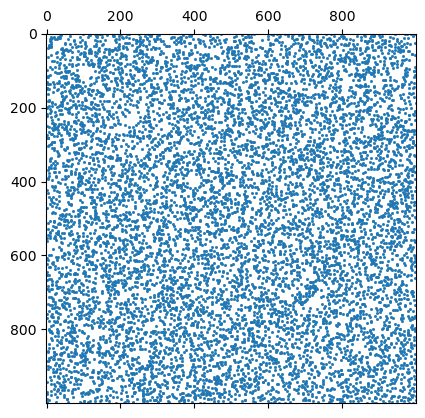

In [26]:
# Plot adjacency matrix
plt.figure(1)
plt.spy(W, precision=0.01, markersize=1)
plt.show()


In [27]:
######################################
# Function that reindexes W according to communities/classes
######################################

######################################
# Usage: 
#   [reindexed_W,reindexed_C] = reindex_W_with_C(W,C)
#
# Notations:
#   n = nb_data
#   nc = nb_communities
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#   C = Classes used for reindexing W. Size = n x 1. Values in [0,1,...,nc-1].
#
# Output variables:
#   reindexed_W = reindexed adjacency matrix. Size = n x n.
#   reindexed_C = reindexed classes C. Size = n x 1. Values in [0,1,...,nc-1].
######################################

def reindex_W_with_classes(W,C):
    n = C.shape[0] # nb of vertices
    nc = len(np.unique(C)) # nb of communities
    reindexing_mapping = np.zeros([n]) # mapping for reindexing W
    reindexed_C = np.zeros([n]) # reindexed C
    tot = 0
    for k in range(nc):
        cluster = (np.where(C==k))[0]
        length_cluster = len(cluster)
        x = np.array(range(tot,tot+length_cluster))
        reindexing_mapping[cluster] = x
        reindexed_C[x] = k
        tot += length_cluster
        
    idx_row,idx_col,val = scipy.sparse.find(W)
    idx_row = reindexing_mapping[idx_row]
    idx_col = reindexing_mapping[idx_col]
    reindexed_W = scipy.sparse.csr_matrix((val, (idx_row, idx_col)), shape=(n, n))

    return reindexed_W,reindexed_C
    

In [28]:
# community indices start at 1
# -1 to start at 0
C = community - 1
[W,C] = reindex_W_with_classes(W,C)


### Question 4 : Plot the adjacency matrix W re-indexed with the ground truth communities.

Does it reveal any interesting structure?


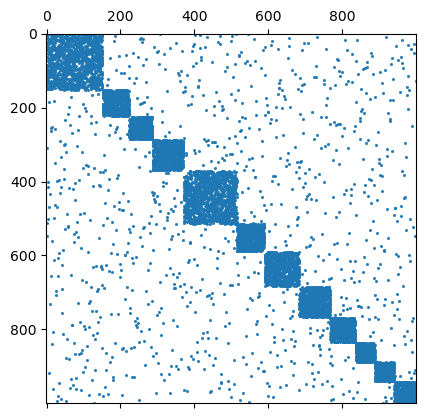

In [29]:
# Plot same W but according to communities
plt.figure(2)
plt.spy(W,precision=0.01, markersize=1)
plt.show()


### Comment : The rest of the notebook if for visualizing the graph in 2D and 3D spaces

We will study graph visualization later.


In [30]:
######################################
# Graph Laplacian Operator
######################################

######################################
# Usages: 
#   L = compute_graph_laplacian(W); # compute normalized graph Laplacian
#   L = compute_graph_laplacian(W,False); # compute UNnormalized graph Laplacian
#
# Notations:
#   n = nb_data
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#
# Output variables:
#   L = Graph Laplacian. Size = n x n.
######################################

def graph_laplacian(W, normalized=True):
    
    # Degree vector
    d = W.sum(axis=0)

    # Laplacian matrix
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype)) # d += epsilon
        d = 1.0 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D
    return L
    

In [31]:
######################################
# Visualization technique:
#   Belkin-Niyogi, Laplacian eigenmaps for dimensionality reduction and data representation, 2003
######################################

######################################
# Usage: 
#   [X,Y,Z] = compute_non_linear_dim_reduction(W)
#
# Notations:
#   n = nb_data
#
# Input variables:
#   W = Adjacency matrix. Size = n x n.
#
# Output variables:
#   X = 1st data coordinates in low-dim manifold. Size n x 1.
#   Y = 2nd data coordinates in low-dim manifold. Size n x 1.
#   Z = 3rd data coordinates in low-dim manifold. Size n x 1.
######################################

def sort(lamb, U):
    idx = lamb.argsort()
    return lamb[idx], U[:,idx]

def compute_non_linear_dim_reduction(W):
    
    # Compute normalized graph Laplacian
    L = graph_laplacian(W)
    
    # Regularization for ill-posed graphs
    L = L + 1e-6* scipy.sparse.identity(L.shape[0], dtype=W.dtype)

    # Compute the first three Laplacian Eigenmaps
    lamb, U = scipy.sparse.linalg.eigsh(L, k=4, which='SM')
    
    # Sort eigenvalue from smallest to largest values
    lamb, U = sort(lamb, U)
    
    # Coordinates of graph vertices in the low-dim embedding manifold
    X = U[:,1]
    Y = U[:,2]
    Z = U[:,3]

    return X,Y,Z

[X,Y,Z] = compute_non_linear_dim_reduction(W)
#print(X.shape)


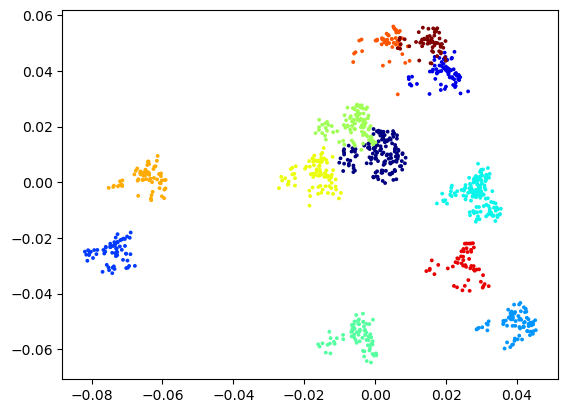

In [32]:
# Visualize the social network in 2D
plt.figure(3)
plt.scatter(X, Y, c=C, s=3, color=pyplot.jet())
plt.show()


In [ ]:
# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=3, color=C, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="3D visualization of LFR graph") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()


: 

# Lecture : Introduction to Graph Science

## Lab 02 : Modes of variations of a graph system -- Exercise

### Xavier Bresson, Nian Liu 


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/02_Graph_Science'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io # Import data
import sys; sys.path.insert(0, 'lib/')
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")


In [10]:
# Load disco-boy network
mat = scipy.io.loadmat('datasets/discoboy_network.mat')
X = mat['X']
W = mat['W']
print(X.shape,W.shape)
print( type(W), type(X), X.dtype, W.dtype )


(2000, 2) (2000, 2000)
<class 'scipy.sparse._csc.csc_matrix'> <class 'numpy.ndarray'> float64 float64


In [ ]:
# first 5 rows of X
# X is the feature matrix
# each row is a node, each column is a feature
# in this example, these are coordinates of the nodes in 2D
X[:5,:]  

array([[ 27.752 ,  92.0675],
       [-12.248 ,  22.0675],
       [ 31.752 ,  -1.9325],
       [ -7.248 ,  38.0675],
       [-23.248 , 118.0675]])

In [7]:
print(W)

  (0, 0)	1.0
  (134, 0)	0.5130999213062245
  (817, 0)	0.7707403170044065
  (859, 0)	0.8637454914532641
  (1141, 0)	0.5476144869543573
  (1247, 0)	0.547614486954325
  (1316, 0)	0.7707403170044065
  (1382, 0)	0.8779181721575231
  (1470, 0)	0.5476144869542925
  (1568, 0)	0.44318774369330227
  (1640, 0)	0.9679735931105623
  (1873, 0)	0.7221627722122401
  (1, 1)	1.0
  (1044, 1)	0.9218468460435177
  (1169, 1)	0.7460562740059291
  (1347, 1)	0.746056274005932
  (1409, 1)	0.3890825738658423
  (1429, 1)	0.2675913935556551
  (1486, 1)	0.4807607094339207
  (1546, 1)	0.30980351990655597
  (1588, 1)	0.2507258778694098
  (1872, 1)	0.6549763604019375
  (1986, 1)	0.2507258778694098
  (2, 2)	1.0
  (972, 2)	0.4289940326853688
  :	:
  (1633, 1997)	0.4504597450473296
  (1973, 1997)	0.5940406362560529
  (1997, 1997)	1.0
  (320, 1998)	0.2349233471154652
  (548, 1998)	0.16965289561027255
  (908, 1998)	0.20624347549671213
  (1041, 1998)	0.7707403170044065
  (1230, 1998)	0.8779181721575231
  (1342, 1998)	0.4807

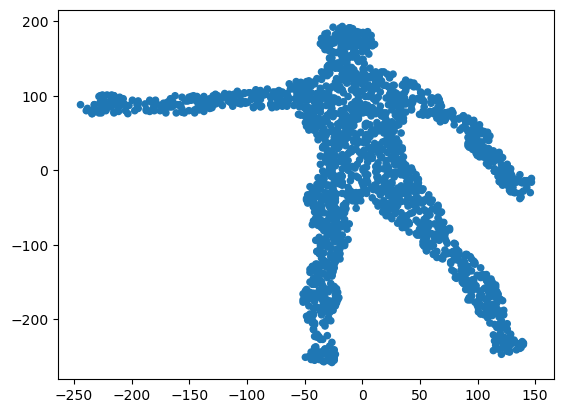

In [12]:
# Visualize the dataset in 2D
plt.figure(1)
size_vertex_plot = 20.
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(X.shape[0]), color=pyplot.jet())
plt.show()


In [ ]:
# Compute graph Laplacian
L = graph_laplacian(W)

# Compute modes of variations of graph system = Fourier functions
lamb, U = scipy.sparse.linalg.eigsh(L, k=9, which='SM')
# this is computing the first 9 smallest eigenvalues (lamb) and 
# their corresponding eigenvectors (U) of the sparse matrix L (the graph Laplacian).
# SM means smallest magnitude, which is the default option.
# To compute the largest magnitude eigenvalues, you can use 'LM' instead.
# U: each column is an eigenvector
# lamb: eigenvalues


### Question 1 : Plot the Fourier functions of the human silhouette, encoded by a k-NN graph

The Fourier functions are given by the columns of the eigenvector matrix U, which can be computed using the `scipy` library:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html

Hint: You can use the `scatter()` function to plot the data:  
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

Examine the Fourier functions, particularly focusing on their oscillatory characteristics.

Can you identify any trends or properties in the oscillations?


In [14]:
U[:,0], lamb[0] # First mode of variation, first eigenvector

(array([-0.02422067, -0.02029305, -0.02473047, ..., -0.02324925,
        -0.01969845, -0.02093765]),
 1.315256963274466e-16)

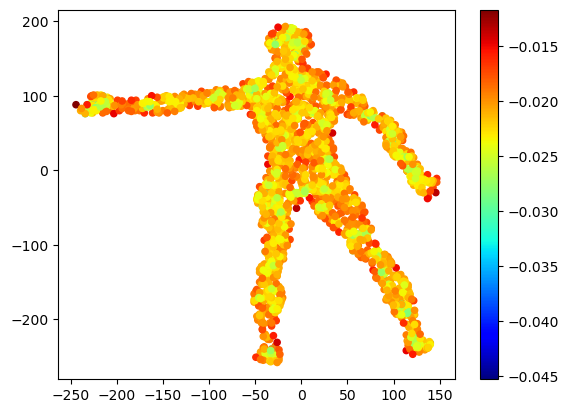

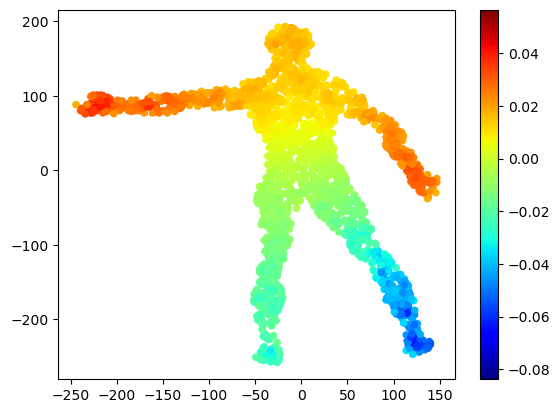

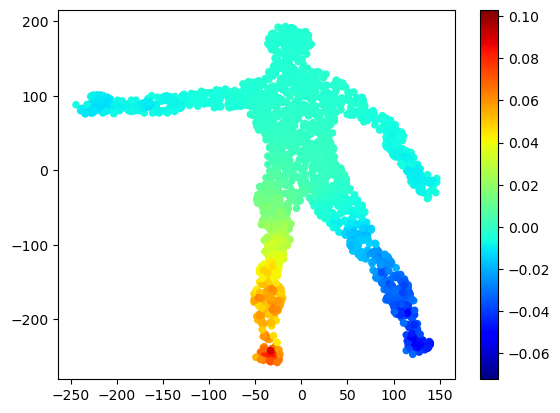

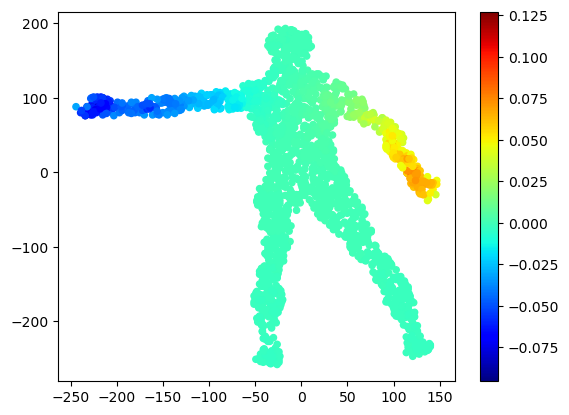

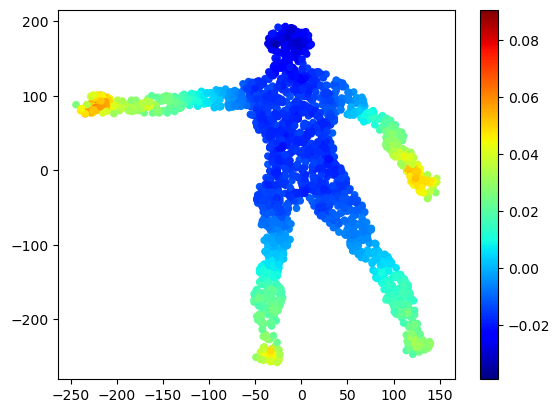

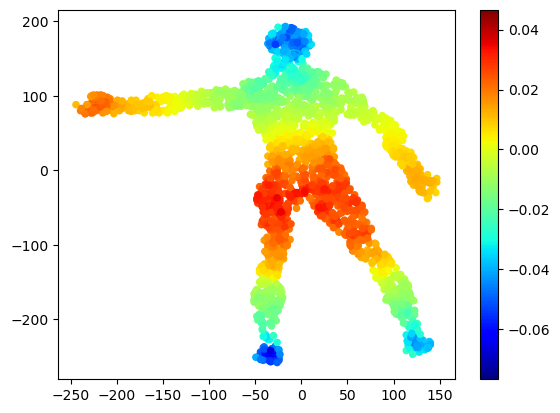

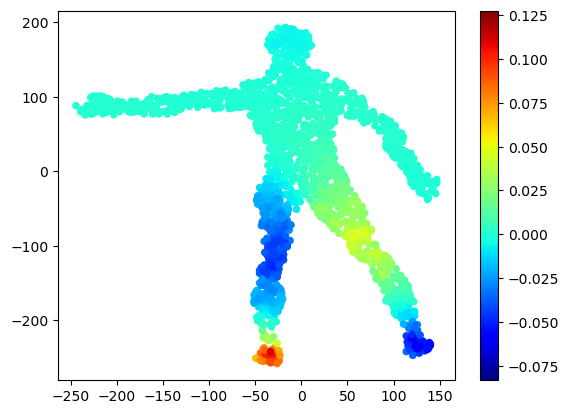

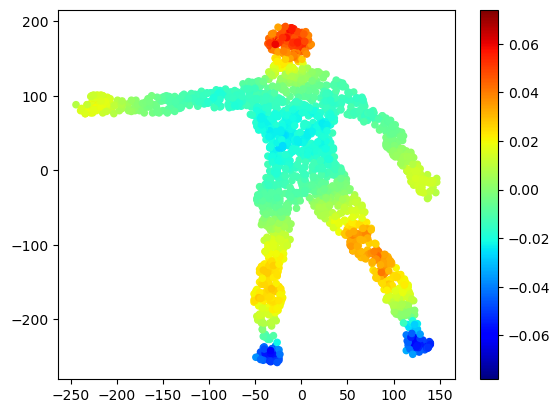

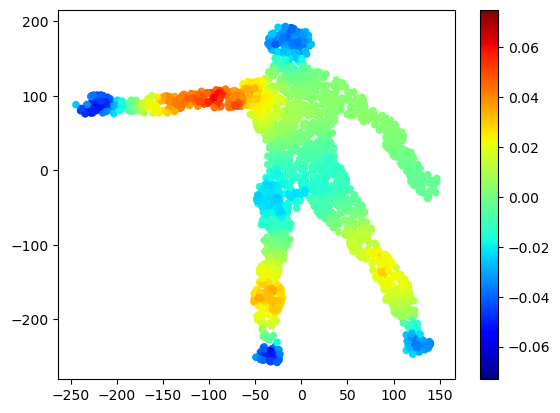

In [ ]:
# Plot mode of variations
for i in range(1,10):
    plt.figure(str(10+i))
    # YOUR CODE HERE 

    plt.scatter(X[:,0], X[:,1], c=U[:,i-1], s=size_vertex_plot*np.ones(X.shape[0]), color=pyplot.jet())
    plt.colorbar()
    plt.show()
    # Explain
    
    # X[:,0], X[:,1]: coordinates of the nodes
    # U[:,i-1]: the i-th mode of variation (eigenvector)
    # size_vertex_plot: size of the vertex in the plot
    # color=pyplot.jet(): use the jet colormap to color the nodes based on
    
    # In the scatter plot, each node is colored according to the value of 
    # the i-th element of the selected eigenvector.

# as i become bigger, the modes of variations become more complex and capture higher frequencies of the graph structure.
# 1st plot has the smoothiest variation, and becoming more oscillatory.

### Question 2 : Plot the Fourier functions of a standard grid, represented by a k-NN graph

As you plot the Fourier functions for a standard grid, consider if they look familiar.

What are these functions commonly called?


(2500, 2) (2500, 2500)


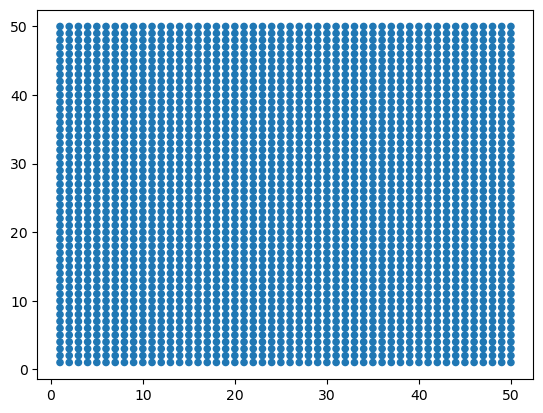

In [15]:
# Load grid network (for images)
mat = scipy.io.loadmat('datasets/grid_network.mat')
X = mat['X']
W = mat['W']
print(X.shape,W.shape)

# Visualize the network in 2D
plt.figure(20)
size_vertex_plot = 20.
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(X.shape[0]), color=pyplot.jet())
plt.show()


In [17]:
# X: feature matrix
# W: adjacency matrix
print(X.shape, W.shape)
print( type(W), type(X), X.dtype, W.dtype )
print(X[:5,:])

(2500, 2) (2500, 2500)
<class 'scipy.sparse._csc.csc_matrix'> <class 'numpy.ndarray'> uint8 float64
[[1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]]


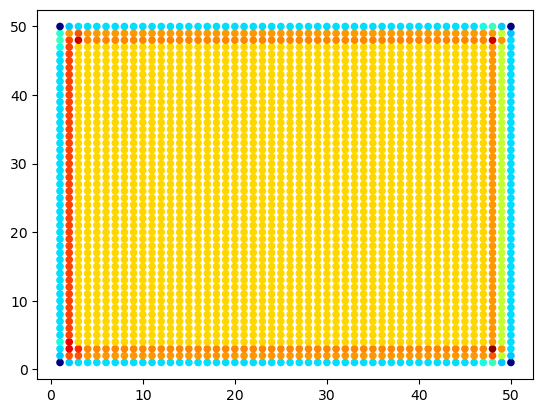

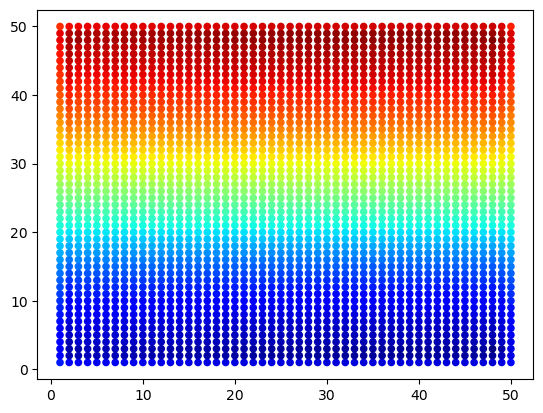

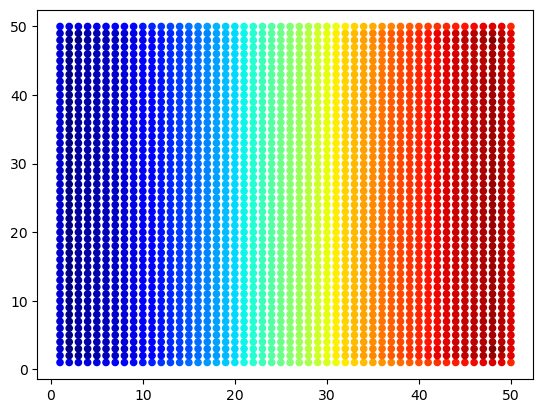

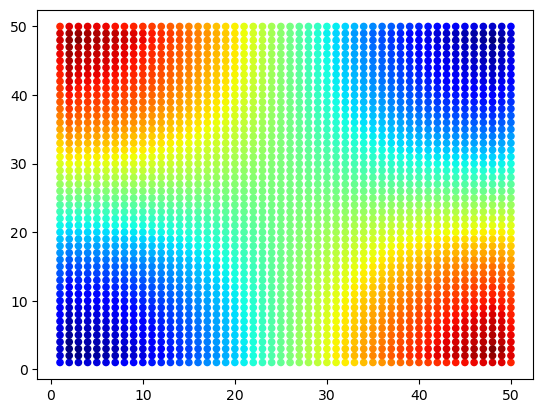

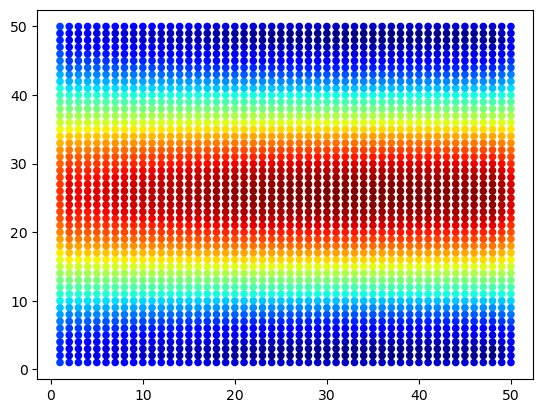

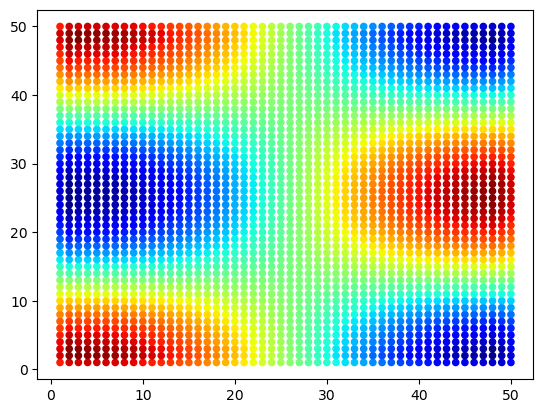

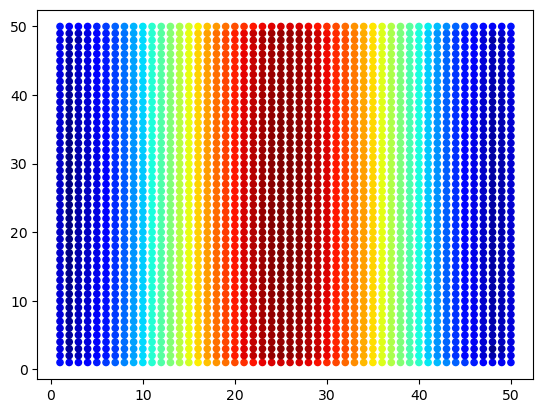

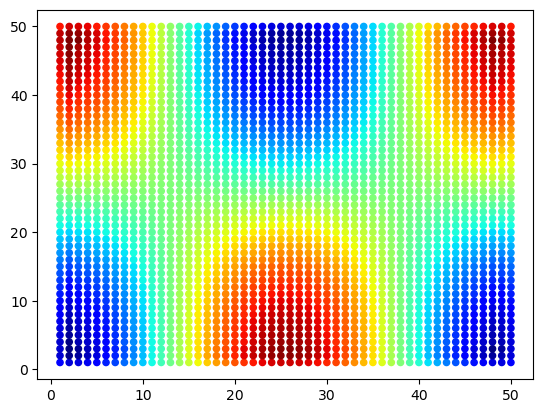

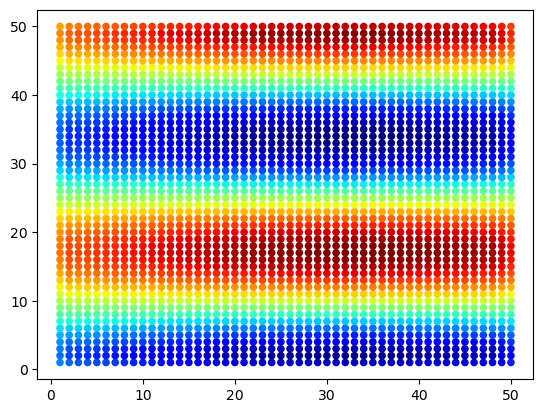

In [18]:
# Compute graph Laplacian
L = graph_laplacian(W)

# Compute modes of variations of graph system = Fourier functions
lamb, U = scipy.sparse.linalg.eigsh(L, k=9, which='SM')

# Plot mode of variations
for i in range(1,10):
    plt.figure(str(20+i))
    # YOUR CODE HERE 
    plt.scatter(X[:,0], X[:,1], c=U[:,i-1], s=size_vertex_plot*np.ones(X.shape[0]), color=pyplot.jet())
    plt.show()
    

In [ ]:
# prints the number of nonzero entries (i.e., the number of neighbors) 
# for the first node in the adjacency matrix W.

# this should be equal to the number of edges connected to the first node
# which is KNN graph's k
print(W[0].data.shape[0])

10


: 

# Lecture : Introduction to Graph Science

## Lab 03 : Graph construction with pre-processing -- Exercise

### Xavier Bresson, Nian Liu 


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/02_Graph_Science'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.sparse # sparse matrix
import scipy.sparse.linalg
from matplotlib import pyplot
import scipy.io # import data
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
import sklearn.metrics.pairwise # distance function
import warnings; warnings.filterwarnings("ignore")


(2000, 100) (2000,)


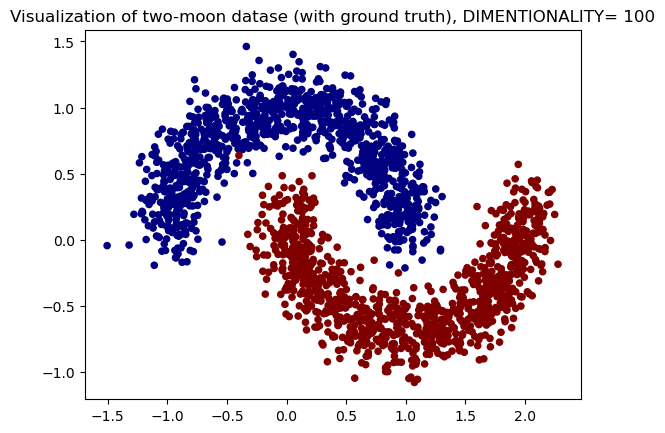

In [2]:
# Load two-moon datasets
mat = scipy.io.loadmat('datasets/two_moon_100D.mat'); dim = 100
#mat = scipy.io.loadmat('datasets/two_moon_2D.mat'); dim = 2
X = mat['X']
n = X.shape[0]; C = np.zeros([n]); C[-int(n/2):] = 1
print(X.shape,C.shape)
# X: 2000 data, each has 100 dimensions
# C: 2000 labels, binary (0 or 1)

# Visualize in 2D
plt.figure(1)
size_vertex_plot = 20.
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Visualization of two-moon datase (with ground truth), DIMENTIONALITY= ' + str(dim))
plt.show()


### Question 1 : Center the dataset X and plot the result

Given a dataset $X\in\mathbb{R}^{n\times d}$, centering it to have zero mean involves subtracting the mean of the dataset from each data point: 

$x_i \ \leftarrow x_i - \textrm{mean}(\{x_i\}_{i=1}^n)\in\mathbb{R}^d$


(2000, 100)


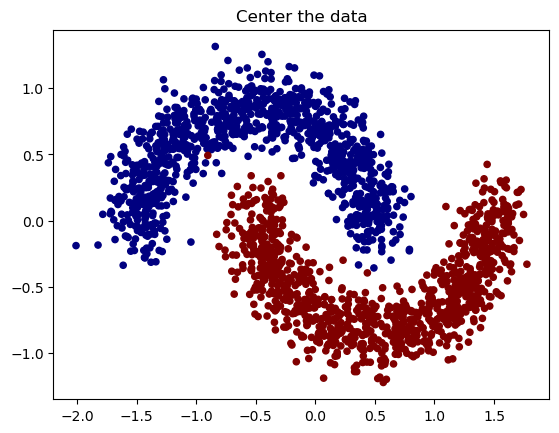

In [3]:
# size(X) = nb_data x dim
# YOUR CODE HERE

# axis 0: along the rows, i.e., compute the mean for each column (feature)
mean = np.mean(X, axis=0)
Xzc = X - mean
print(Xzc.shape)

plt.figure(2)
# YOUR CODE HERE 
plt.scatter(Xzc[:,0], Xzc[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Center the data')
plt.show()


### Question 2 : Normalize the variance of the dataset X and plot the result

To normalize the variance of the dataset $X\in\mathbb{R}^{n\times d}$, divide each data point by the standard deviation of the dataset:

$x_i \ \leftarrow x_i / \textrm{std}(\{x_i\}_{i=1}^n)\in\mathbb{R}^d$


(2000, 100)


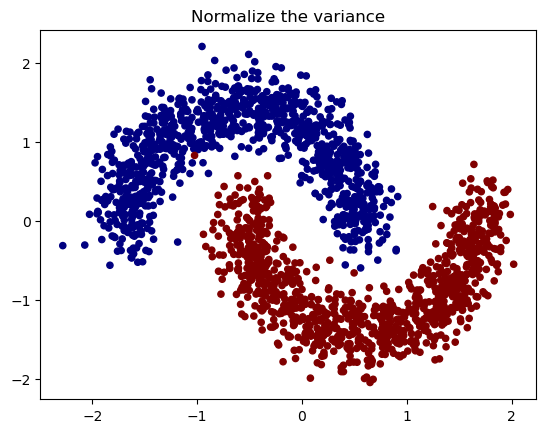

In [ ]:
# size(X) = nb_data x dim
# YOUR CODE HERE 
# this to have each feature (column) have variance 1
std = np.std(Xzc, axis=0) + 1e-10
Xnvar = Xzc / std
# equivalent to
# Xnvar = Xzc/ (np.sqrt(np.sum(Xzc**2,axis=0)/Xzc.shape[0])+1e-10)


# this is normalize the L2 norm of each feature to 1
#Xnvar = Xzc / np.sqrt(np.sum(Xzc**2, axis=0) + 1e-10)

print(Xnvar.shape)

plt.figure(3)
# YOUR CODE HERE
plt.scatter(Xnvar[:,0], Xnvar[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Normalize the variance')
plt.show()


### Question 3 : Project the dataset X onto a unit sphere and plot the result

To project a dataset $X\in\mathbb{R}^{n\times d}$ onto a unit sphere, normalize each data point by its Euclidean norm:

$x_i \ \leftarrow x_i /||x_i||_2 \in\mathbb{R}^d$


(2000, 100)


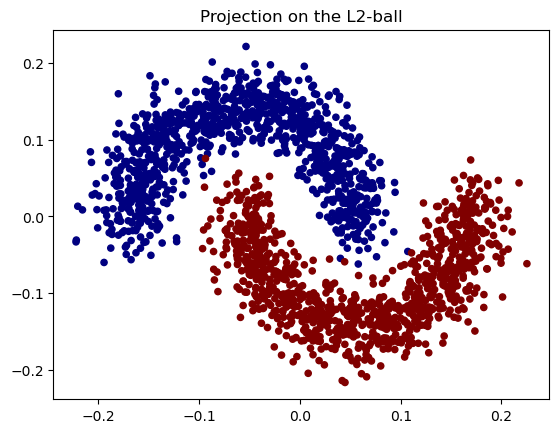

In [6]:
# size(X) = nb_data x dim
# YOUR CODE HERE 
# Xnorm shape: (nb_data,), it is 1d, not 2d
Xnorm = np.sqrt(np.sum(Xnvar**2, axis=1)) + 1e-10


Xl2proj = (Xnvar.T / Xnorm).T
# Or equivalently, to make Xnorm a column vector
# Xl2proj = Xnvar / Xnorm[:, np.newaxis]
# Xl2proj = Xnvar / Xnorm[:, None]
# Xl2proj = Xnvar / Xnorm.reshape(-1, 1)

print(Xl2proj.shape)

# sanity check, length for each row should be 1
assert np.all(np.sqrt(np.sum(Xl2proj**2,axis=1)) - 1 < 1e-5)

plt.figure(4)
# YOUR CODE HERE
plt.scatter(Xl2proj[:,0], Xl2proj[:,1], s=size_vertex_plot*np.ones(n), c=C, color=pyplot.jet())
plt.title('Projection on the L2-ball')
plt.show()


### Question 4 : Construct a k-NN graph using L2/Euclidean distance

1. **Center the Dataset:** Begin by centering the dataset X to have a mean of zero.
   
2. **Compute Pairwise Distances:** Calculate the pairwise Euclidean distances D between all data points. You can use the `pairwise_distances()` function from the `sklearn` library: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html.

3. **Sort Distance Matrix:** Organize the distance matrix D in ascending order, from the smallest to the largest distances.

4. **Extract k-NN:** Identify the k-nearest neighbors for each data point based on the sorted distance matrix.

5. **Compute Adjacency Matrix:** Create the adjacency matrix W using Gaussian weights. This involves applying the Gaussian function to the distances.

6. **Make Adjacency Matrix Sparse:** Convert the adjacency matrix W into a sparse matrix to optimize storage and computation.

7. **Symmetrize Matrix:** Ensure the adjacency matrix W is symmetric by averaging W with its transpose.


In [ ]:
######################################
# Construct a k-NN graph with L2/Euclidean distance
######################################

# Compute L2/Euclidean distance between all pairs of points
Xzc = X - np.mean(X,axis=0) # zero-centered data
# YOUR CODE HERE 
D = sklearn.metrics.pairwise.pairwise_distances(X, metric='euclidean', n_jobs=1)
print(D.shape)

# Sort distance matrix
k = 10 # number of nearest neighbors
idx = np.argsort(D)[:,:k] # first k columns of all row, indices of k nearest neighbors
Dnot_sorted = np.copy(D)
D.sort() # sort D from smallest to largest values
Dsorted = np.copy(D)
print(D.shape)
D = D[:,:k]
print(D.shape)

# Compute weight matrix
# here sigma2 is the average squared distance of 
# each point to its k-th nearest neighbor, it's global scale
# see slide 38 of lecture 2
sigma2 = np.mean(D[:,-1])**2 # graph scale
W = np.exp(- D**2 / sigma2)
print(W.shape)

# Make W sparse
n = X.shape[0]
row = np.arange(0, n).repeat(k) # [0,...,0,(total k times), 1,...,1,(total k times), ..., n-1,n-1,...,n-1(total k times)]
col = idx.reshape(n*k) # flatten idx to a vector of size n*k
# e.g., if idx = [[1,2,3],[0,2,3],[0,1,3]], then col = [1,2,3,0,2,3,0,1,3]
data = W.reshape(n*k) # flatten W to a vector of size n*k

# row: starting node index of edge
# col: ending node index of edge
# data: weight of the edge
W = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, n))

# Make W is symmetric
bigger = W.T > W
# For each pair (i, j), keep the larger weight between W[i, j] and W[j, i], 
# making the matrix symmetric.
W = W - W.multiply(bigger) + W.T.multiply(bigger)

# No self-connections
#W.setdiag(0)

# Print the shape of the adjacency matrix 
# and the number of nonzero entries (edges).
print(W.shape)
print(W.nnz)


(2000, 2000)
(2000, 2000)
(2000, 10)
(2000, 10)
(2000, 2000)
31388


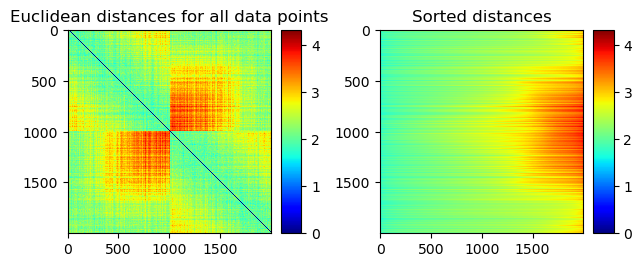

In [9]:
# Visualize distances
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.suptitle('Title of figure 2', fontsize=15)

ax1.set_title('Euclidean distances for all data points')
im1 = ax1.imshow(Dnot_sorted, interpolation='nearest')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.1)
ax1.get_figure().colorbar(im1, cax=cax1)

ax2.set_title('Sorted distances')
im2 = ax2.imshow(Dsorted, interpolation='nearest')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="10%", pad=0.1)
ax2.get_figure().colorbar(im2, cax=cax2)

fig.tight_layout()

fig.show()


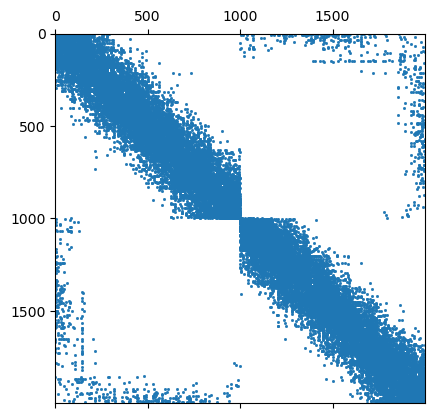

In [10]:
plt.figure(5)
plt.spy(W,precision=0.01, markersize=1, color=pyplot.jet())
plt.show()


### Comment

To assess the quality of the constructed adjacency matrix, one effective approach is to compute the classification error relative to some ground truth communities.

In this notebook, we evaluate the adjacency matrix by comparing the ground truth communities C with the communities estimated using the NCut graph partitioning algorithm: http://www.cis.upenn.edu/~jshi/software.


In [11]:
Cncut, acc = compute_ncut(W, C, 2)
print(acc)


93.89999999999999


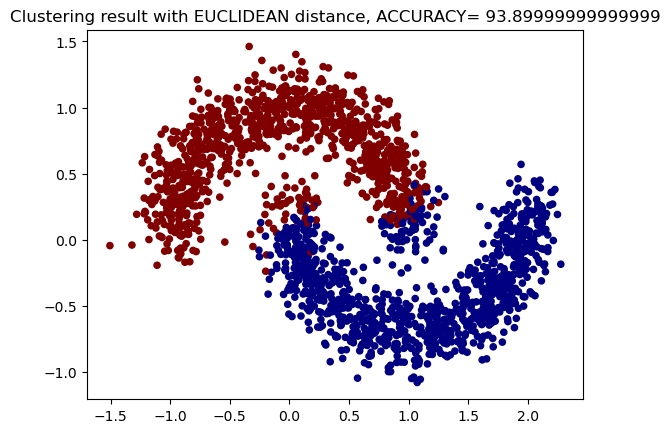

In [12]:
plt.figure(6)
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cncut, color=pyplot.jet())
plt.title('Clustering result with EUCLIDEAN distance, ACCURACY= '+ str(acc))
plt.show()


### Question 5 : Construct a k-NN graph using cosine distance

1. **Construct k-NN Graph:** Build a k-NN graph using cosine distance as the metric. The cosine distance may be computed using the `arccos()` function from NumPy: https://numpy.org/doc/stable/reference/generated/numpy.arccos.html.

2. **Evaluate Quality:** Assess the quality of the adjacency matrix construction by comparing it with the ground truth communities. Use the NCut graph partitioning algorithm to estimate communities and evaluate the performance.



In [15]:
######################################
# Construct k-NN graph with Cosine distance
######################################

# Compute Cosine distance between all pairs of points
Xzc = X - np.mean(X,axis=0) # zero-centered data
Xl2proj = ( Xzc.T / np.sqrt(np.sum(Xzc**2,axis=1)+1e-10) ).T # Projection on the sphere, i.e. ||x_i||_2 = 1
# cosine distance = x_i^T x_j / (||x_i||_2 ||x_j||_2) = x_i^T x_j since the length is always 1
D = Xl2proj.dot(Xl2proj.T)
#print(D.shape)

# Sort D according in descending order
k = 10 # number of nearest neighbors
idx = np.argsort(D)[:,::-1][:,:k] # indices of k nearest neighbors
Dnot_sorted = np.copy(D)
D.sort(axis=1)
D[:] = D[:,::-1]
Dsorted = np.copy(D)

# Cosine distance
# YOUR CODE HERE 
Dcos = np.abs(np.arccos(D))
D = Dcos
D = D[:,:k]
print(D.shape)

# Compute Weight matrix
sigma2 = np.mean(D[:,-1])**2 # graph scale
W = np.exp(- D**2 / sigma2)
#print(W.shape)

# Make W sparse
n = X.shape[0]
row = np.arange(0, n).repeat(k)
col = idx.reshape(n*k)
data = W.reshape(n*k)
W = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, n))

# Make W is symmetric
bigger = W.T > W
W = W - W.multiply(bigger) + W.T.multiply(bigger)

# No self-connections
#W.setdiag(0)

print(W.shape)
print(W.nnz)


(2000, 10)
(2000, 2000)
32914


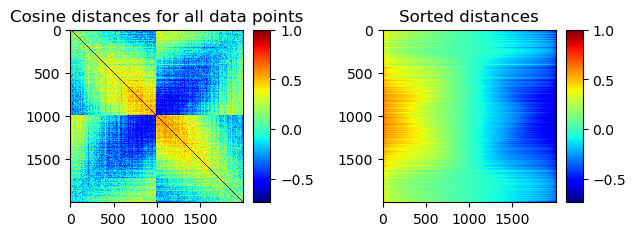

In [16]:
# Visualize distances
fig, (ax1, ax2) = plt.subplots(1,2)
#fig.suptitle('Title of figure 2', fontsize=15)

ax1.set_title('Cosine distances for all data points')
im1 = ax1.imshow(Dnot_sorted, interpolation='nearest')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.1)
ax1.get_figure().colorbar(im1, cax=cax1)

ax2.set_title('Sorted distances')
im2 = ax2.imshow(Dsorted, interpolation='nearest')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="10%", pad=0.1)
ax2.get_figure().colorbar(im2, cax=cax2)

fig.tight_layout()

fig.show()


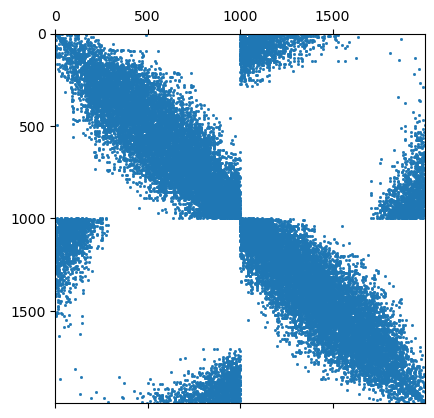

In [17]:
plt.figure(7)
plt.spy(W,precision=0.01, markersize=1, color=pyplot.jet())
plt.show()


In [18]:
Cncut, acc = compute_ncut(W, C, 2)
print(acc)


80.35


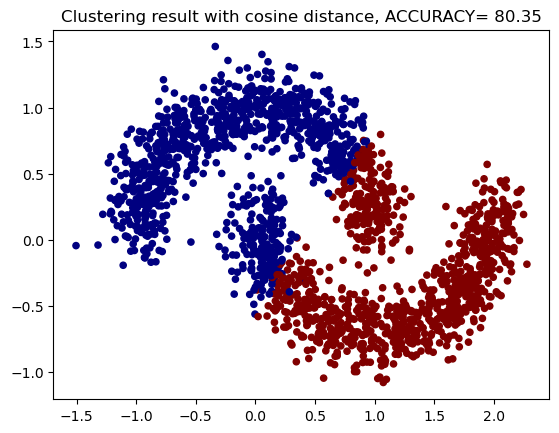

In [ ]:
plt.figure(8)
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cncut, color=pyplot.jet())
plt.title('Clustering result with cosine distance, ACCURACY= '+ str(acc))
plt.show()
# not as good as Euclidean distance


# Lecture : Introduction to Graph Science

## Lab 04 : Construct a network of text documents -- Exercise

### Xavier Bresson, Nian Liu  


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/02_Graph_Science'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [1]:
# Load libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook 
import matplotlib.pyplot as plt
import pylab # 3D visualization
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
import scipy.io # import data
import sys; sys.path.insert(0, 'lib/')
from lib.utils import compute_ncut
from lib.utils import reindex_W_with_classes
from lib.utils import nldr_visualization
from lib.utils import construct_knn_graph
import warnings; warnings.filterwarnings("ignore")


### Question

In the previous notebook, we examined a graph of images and noted that the quality of the adjacency matrix construction remained relatively fine whether using Euclidean distance or cosine distance.

In this notebook, we will analyze a graph of text documents, where each document is represented by a histogram of words.

1. **Characteristics of Text Document Histograms:** What is the key feature of text documents represented by histograms of words?

2. **Compare Graph Construction Quality:** Run and compare the quality of graph construction both visually and quantitatively using the NCut graph partitioning algorithm, given the ground truth communities.

3. **Best Graph Construction Approach:** Determine which graph construction method — Euclidean distance or cosine distance — is more effective for this type of graph.


In [2]:
# Load 10 classes of 4,000 text documents
mat = scipy.io.loadmat('datasets/20news_5classes_raw_data.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print(n,d,nc)


2000 7939 5


In [5]:
Cgt.shape

(2000,)

In [6]:
# Compute the k-NN graph with L2/Euclidean distance
W_euclidean = construct_knn_graph(X, 10, 'euclidean')
#print(W_euclidean)


k-NN graph with euclidean distance


In [7]:
Cncut,acc = compute_ncut(W_euclidean, Cgt, nc)
print(acc)


20.349999999999998


In [8]:
[reindexed_W_gt,reindexed_C_gt] = reindex_W_with_classes(W_euclidean,Cgt)
[reindexed_W_ncut,reindexed_C_ncut] = reindex_W_with_classes(W_euclidean,Cncut)


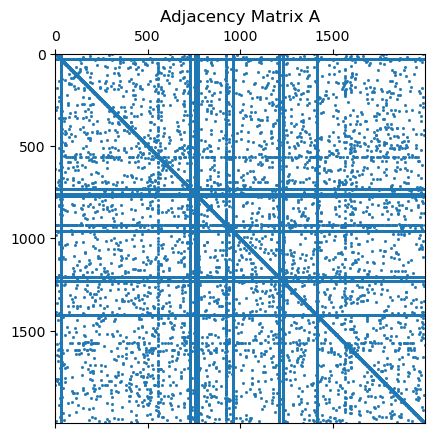

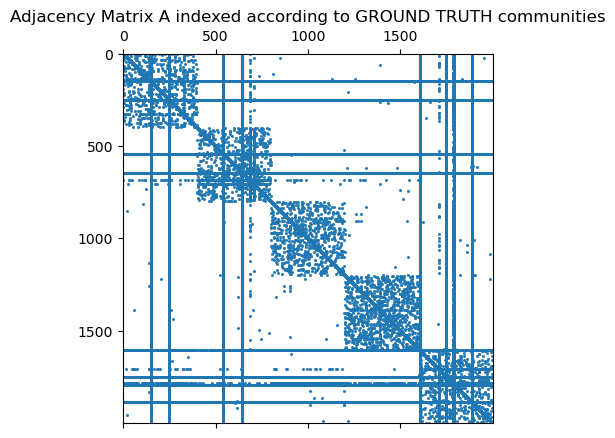

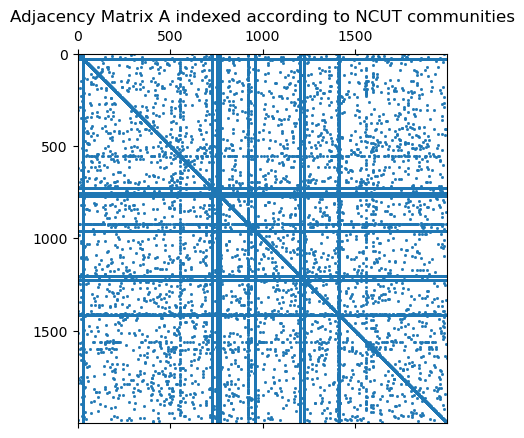

In [9]:
plt.figure(1)
plt.spy(W_euclidean,precision=0.01, markersize=1)
plt.title('Adjacency Matrix A')
plt.show()

plt.figure(2)
plt.spy(reindexed_W_gt,precision=0.01, markersize=1)
plt.title('Adjacency Matrix A indexed according to GROUND TRUTH communities')
plt.show()

plt.figure(3)
plt.spy(reindexed_W_ncut,precision=0.01, markersize=1)
plt.title('Adjacency Matrix A indexed according to NCUT communities')
plt.show()


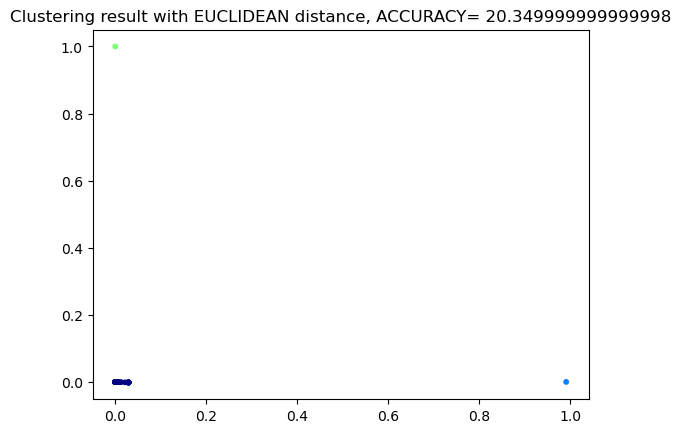

<Figure size 640x480 with 0 Axes>

In [14]:
# Visualization
[X,Y,Z] = nldr_visualization(W_euclidean)

plt.figure(4)
size_vertex_plot = 10
plt.scatter(X, Y, s=size_vertex_plot*np.ones(n), c=Cncut, color=pyplot.jet())
plt.title('Clustering result with EUCLIDEAN distance, ACCURACY= '+ str(acc))
plt.show()

# 3D Visualization
fig = pylab.figure(5)
ax = Axes3D(fig)
ax.scatter(X, Y, Z, c=Cncut, color=pyplot.jet())
pyplot.show()


In [15]:
# Compute the k-NN graph with Cosine distance
X = mat['X']
W_cosine = construct_knn_graph(X,10,'cosine')

Cncut, acc = compute_ncut(W_cosine, Cgt, nc)
print(acc)


k-NN graph with cosine distance
74.25


In [16]:
[reindexed_W_gt,reindexed_C_gt] = reindex_W_with_classes(W_cosine,Cgt)
[reindexed_W_ncut,reindexed_C_ncut] = reindex_W_with_classes(W_cosine,Cncut)


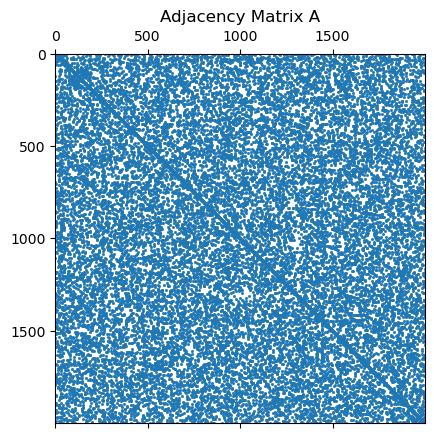

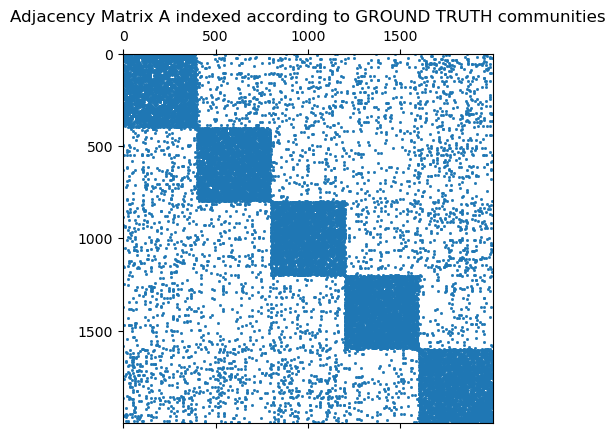

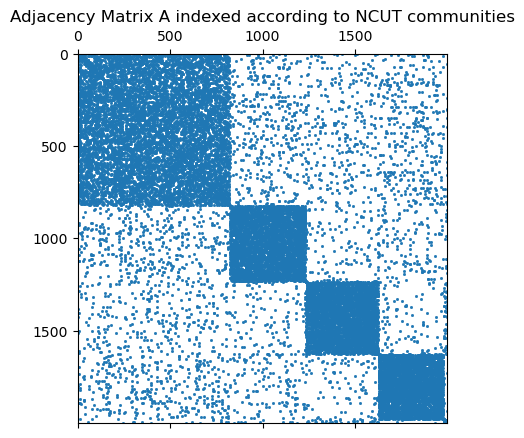

In [17]:
plt.figure(6)
plt.spy(W_cosine,precision=0.01, markersize=1)
plt.title('Adjacency Matrix A')
plt.show()

plt.figure(7)
plt.spy(reindexed_W_gt,precision=0.01, markersize=1)
plt.title('Adjacency Matrix A indexed according to GROUND TRUTH communities')
plt.show()

plt.figure(8)
plt.spy(reindexed_W_ncut,precision=0.01, markersize=1)
plt.title('Adjacency Matrix A indexed according to NCUT communities')
plt.show()


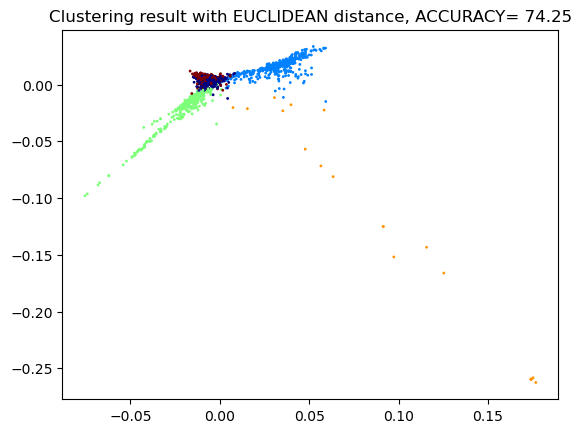

In [ ]:
# Visualization
[X,Y,Z] = nldr_visualization(W_cosine)

plt.figure(9)
size_vertex_plot = 1
plt.scatter(X, Y, s=size_vertex_plot*np.ones(n), c=Cncut, color=pyplot.jet())
plt.title('Clustering result with Cosine distance, ACCURACY= '+ str(acc))
plt.show()



In [12]:
# 3D Visualization
import plotly.graph_objects as go
data = go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=2, color=Cncut, colorscale='jet', opacity=1)) # data as points
# data = go.Scatter3d(x=Xvis, y=Yvis, z=Zvis, mode='markers', marker=dict(size=1, color=C, colorscale='jet', opacity=1, showscale=True)) # w/ colobar 
fig = go.Figure(data=[data]) 
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30, pad=0)) # tight layout but t=25 required for showing title 
fig.update_layout(autosize=False, width=600, height=600, title_text="3D visualization of 20newsgroups graph") # figure size and title
# fig.update_layout(scene = dict(xaxis = dict(visible=False), yaxis = dict(visible=False), zaxis = dict(visible=False))) # no grid, no axis 
# fig.update_layout(scene = dict(xaxis_title = ' ', yaxis_title = ' ', zaxis_title = ' ')) # no axis name 
fig.update_layout(scene = dict(zaxis = dict(showgrid = True, showticklabels = False), zaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(yaxis = dict(showgrid = True, showticklabels = False), yaxis_title = ' ') ) # no range values, no axis name, grid on
fig.update_layout(scene = dict(xaxis = dict(showgrid = True, showticklabels = False), xaxis_title = ' ') ) # no range values, no axis name, grid on
fig.layout.scene.aspectratio = {'x':1, 'y':1, 'z':1}
fig.show()
